# Cyber Data Analytics, CS4035
## Lab assignment 1: Fraud detection
### April 2019

### Importing data from CSV file

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('./data_for_student_case.csv', sep = ',')
data = data[data['simple_journal'] != 'Refused']

orig_shape = data.shape
nas = data.isna()
nas_id = np.sum(nas, 1)

print("Amount of nan values in Chargeback: ", np.sum(data['simple_journal'][nas_id > 0] == 'Chargeback'), "\n")


print("NaN values per feature: \n", np.sum(nas, 0), "\n")

# data = data.dropna()

# print("Number of NaN values omitted: ", orig_shape[0] - data.shape[0])

print(data.dtypes)

labels = data['simple_journal']
print("Number of non-fraud: ", np.sum(labels == 'Settled'), ", with ratio: ", np.sum(labels == 'Settled')/len(labels))
print("Number of fraud: ", np.sum(labels == 'Chargeback'), ", with ratio: ", np.sum(labels == 'Chargeback')/len(labels))
print("Number refused: ", np.sum(labels == 'Refused'), ", with ratio: ", np.sum(labels == 'Refused')/len(labels))

data.groupby(by = 'simple_journal').count()

Amount of nan values in Chargeback:  0 

NaN values per feature: 
 txid                                0
bookingdate                         0
issuercountrycode                   4
txvariantcode                       0
bin                                 0
amount                              0
currencycode                        0
shoppercountrycode                342
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    13194
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64 

txid                              int64
bookingdate                      object
issuercountrycode                object
txvariantcode                    object
bin                             float64
amount                          float64
currencycode                    

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
simple_journal,,,,,,,,,,,,,,,,
Chargeback,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345
Settled,236691,236691,236687,236691,236691,236691,236691,236349,236691,223497,236691,236691,236691,236691,236691,236691


## Convesion of categorical data to numeric

In [2]:
data_cat = data.copy(True)

# data_oneHot = pd.get_dummies(data, columns = ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'accountcode'])

label_mapping = {}

# Convert currency code in order to 'amount' in a single code
label_mapping['numcurrencycode'] = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP':1.13355} 
data['numcurrencycode'] = data['currencycode']
data.replace({'numcurrencycode' : label_mapping['numcurrencycode']}, inplace=True)
data['amount'] = data['amount'] * data['numcurrencycode']

label_mapping['simple_journal'] = {'Settled': 0, 'Chargeback' : 1}
data.replace({'simple_journal' : label_mapping['simple_journal']}, inplace=True)

# Convert all the rest columns which are of type 'object'
char_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index

for c in char_cols:
    data[c], label_mapping[c] = pd.factorize(data[c])

label_mapping

{'numcurrencycode': {'SEK': 0.09703,
  'MXN': 0.04358,
  'AUD': 0.63161,
  'NZD': 0.58377,
  'GBP': 1.13355},
 'simple_journal': {'Settled': 0, 'Chargeback': 1},
 'bookingdate': Index(['2015-11-09 14:26:51', '2015-11-09 14:27:38', '2015-11-23 16:34:16',
        '2015-11-23 16:34:51', '2015-11-09 14:26:08', '2015-11-09 14:26:25',
        '2015-11-09 14:26:47', '2015-11-23 16:34:29', '2015-12-08 19:58:35',
        '2015-11-09 14:25:50',
        ...
        '2015-11-03 08:12:13', '2015-11-03 08:12:14', '2015-11-03 22:33:58',
        '2015-11-03 18:57:00', '2015-11-02 20:34:44', '2015-11-02 20:34:30',
        '2015-10-31 20:04:21', '2015-10-31 22:03:39', '2015-11-02 20:16:57',
        '2015-11-03 18:57:01'],
       dtype='object', length=40160),
 'issuercountrycode': Index(['MX', 'SA', 'CA', 'AR', 'CL', 'CO', 'FR', 'US', 'JP', 'AE',
        ...
        'CW', 'AZ', 'AM', 'DO', 'AI', 'MN', 'PY', 'TM', 'BZ', 'ME'],
       dtype='object', length=116),
 'txvariantcode': Index(['mccredit', 'visa

### HeatMap

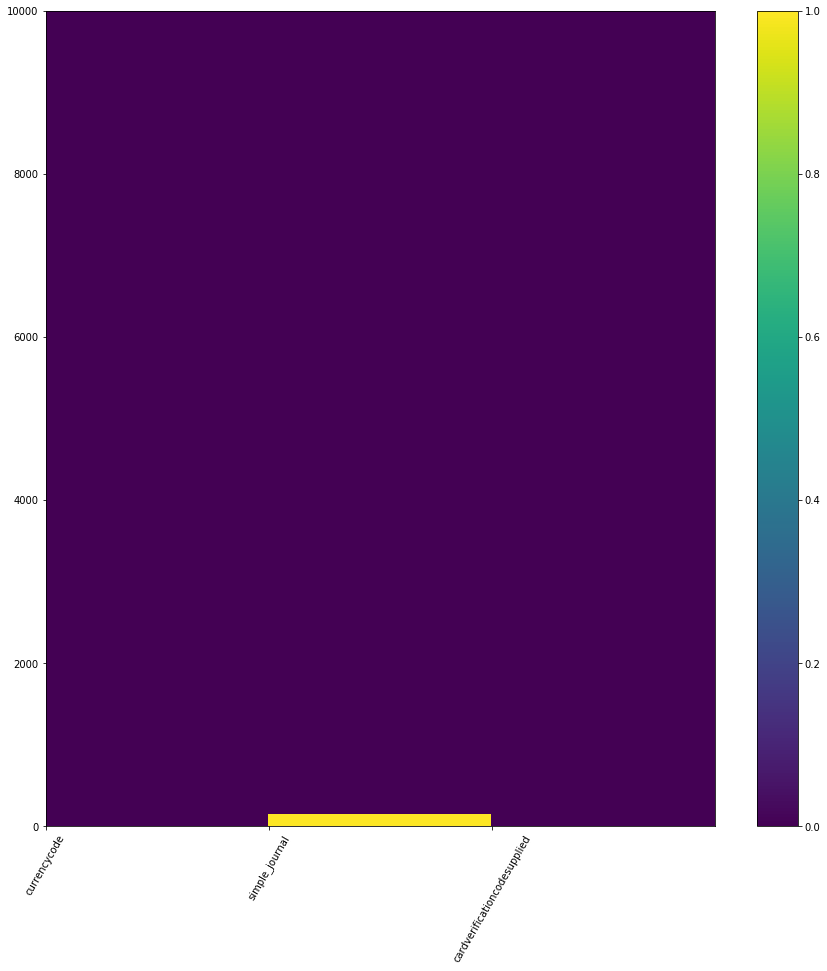

In [69]:
labels = ['currencycode', 'simple_journal', 'cardverificationcodesupplied']

plt.figure(figsize = (15,15))
plt.pcolor(data[labels][:10000])
plt.xticks(np.arange(len(labels)), labels, rotation = 60)
plt.colorbar()

### Aggregated values per card id

(223071, 6)


Text(0.5, 1.0, 'Fraud')

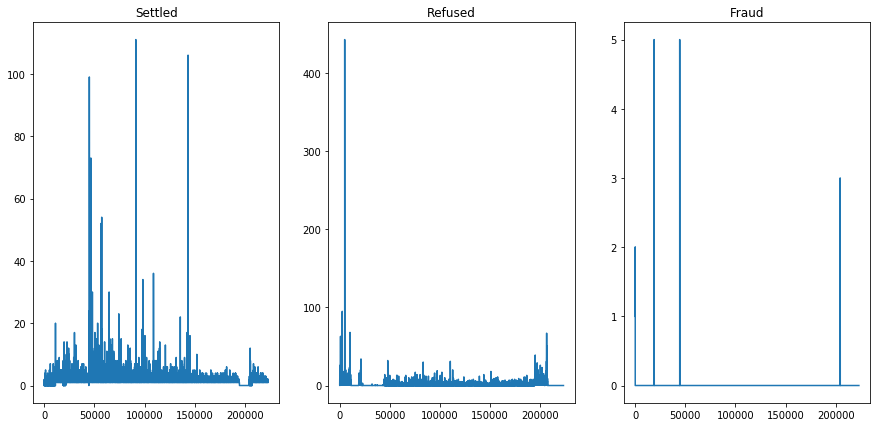

In [32]:
data_agg = data_cat[['card_id', 'simple_journal', 'amount']]

dd = pd.get_dummies(data_agg, columns = ['simple_journal'])

dd['sum_fraud'] = dd['amount'] * dd['simple_journal_Chargeback']
dd['sum_ref'] = dd['amount'] * dd['simple_journal_Refused']
dd['sum_OK'] = dd['amount'] * dd['simple_journal_Settled']

dd_user = dd.groupby(by = 'card_id', sort = False).agg({
    'simple_journal_Settled' : sum,
    'sum_OK' : 'mean',
    'simple_journal_Refused' : sum,
    'sum_ref' : 'mean',
    'simple_journal_Chargeback' : sum,
    'sum_fraud' : 'mean'
})

print(dd_user.values.shape)

# Visualizations
f, ax = plt.subplots(1, 3, figsize = (15,7))
ax[0].plot(dd_user.values[:, 0])
ax[0].set_title("Settled")
ax[1].plot(dd_user.values[:, 2])
ax[1].set_title("Refused")
ax[2].plot(dd_user.values[:, 4])
ax[2].set_title("Fraud")

### Visualizations

Text(0, 0.5, 'mean amount per group')

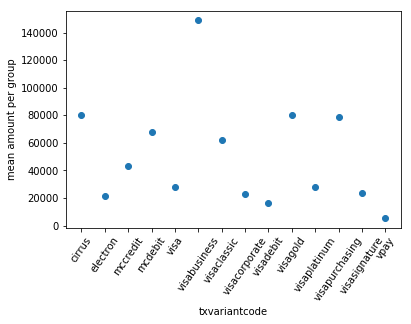

In [35]:
code = data_cat[['txvariantcode', 'amount']].groupby(['txvariantcode']).mean()
code.values
labels = code.index.values
plt.scatter(np.arange(len(code.values)), code.values)
plt.xticks(np.arange(len(code.values)), labels, rotation = '55')
plt.xlabel('txvariantcode')
plt.ylabel('mean amount per group')

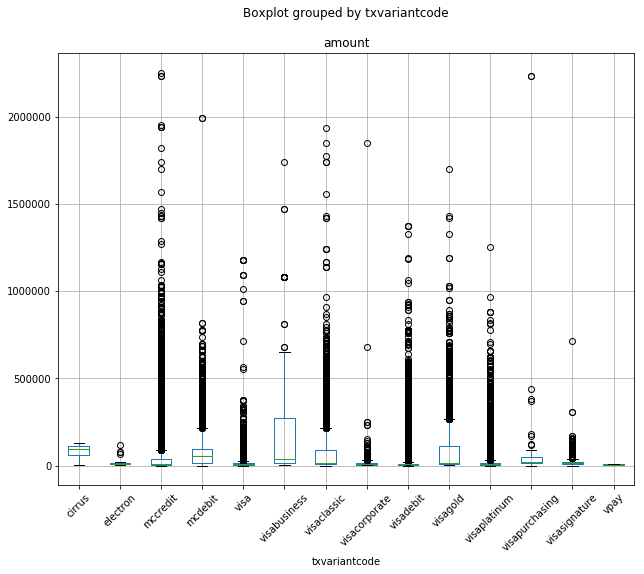

In [36]:
data_cat.boxplot(column = 'amount', by = 'txvariantcode', figsize = (10, 8), rot = '45')

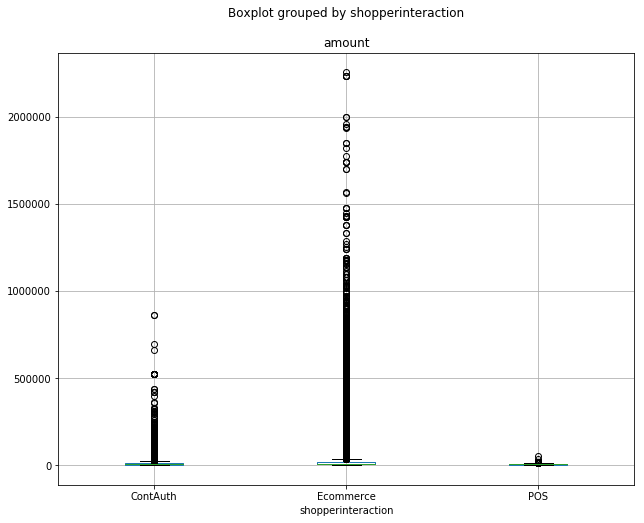

In [38]:
data_cat.boxplot(column = ['amount'], by = 'shopperinteraction', figsize = (10,8))

### Number of IP addresses per card id
#### The more addresses the more suspicious the transactions are

In [40]:
data_cat[['card_id', 'ip_id']].groupby('card_id').nunique().sort_values(by = 'ip_id', ascending = False).head()

,card_id,ip_id
card_id,,
card267365,1,25
card183189,1,25
card11998,1,23
card210128,1,22
card18592,1,20


## Classification

In [3]:
from PlotConfusionMatrix import *
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from RocAnalysis import *
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

# Construct dataset and corresponding labels
X = data.drop(['simple_journal', 'creationdate', 'bookingdate', 'currencycode', 'numcurrencycode'], axis = 1).values
y = data['simple_journal'].values
print("Dataset shape: ", X.shape)

# Imputing missing values.. we could alternatively just remove these samples
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
print(np.sum(np.isnan(X)))
X = imp.fit_transform(X)

imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
X = imp.fit_transform(X)

print("Fraud class samples: ", np.sum(y == 1))
print("Non-fraud class samples: ", np.sum(y == 0))
print("Ratio: ", np.sum(y == 1)/np.sum(y == 0))

# 10-Fold cross validation used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

Dataset shape:  (237036, 13)
0
Fraud class samples:  345
Non-fraud class samples:  236691
Ratio:  0.001457596613305956


### Naive Bayes

#### UNSMOTEd case

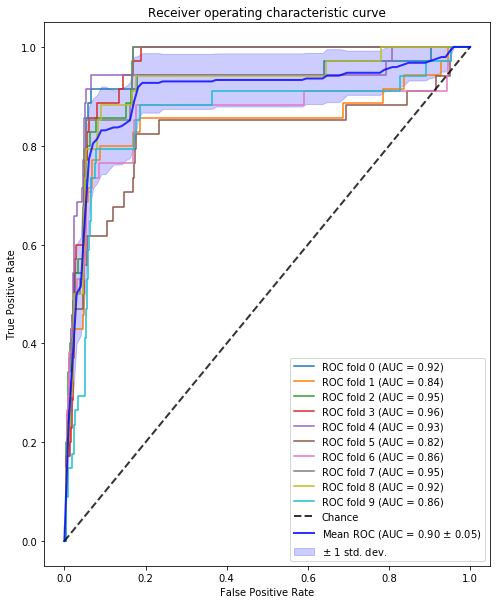

Confusion matrix, without normalization
[[225018  11673]
 [   129    216]]


<Figure size 432x288 with 0 Axes>

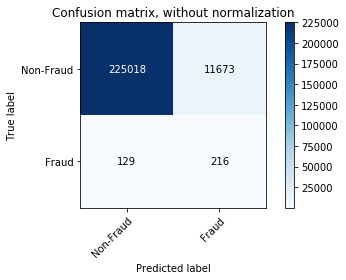

In [16]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
mean_tpr, std_tpr, mean_auc, std_auc, _, _, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

#### SMOTE; first determine the over-sampling ratio

In [17]:
# Use cross-validation to determine the best overasmpling ratio
# ratios = np.arange(0.1, 1, 0.1)
ratios = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([5, 10, 100])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, y, clf, cv, 
                                                                                False, False, False, False, sm)
#         print("Oversamping ratio: ", r, ", with mean AUC: ", np.round(m_auc, 5), " +- ", np.round(std_auc, 7),
#               " and mean F1: ", np.round(m_F1, 5), " +- ", np.round(std_F1, 7))
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

Mean AUC:
 [[0.90307105 0.90355148 0.89113912]
 [0.9031016  0.90215262 0.88946524]
 [0.90317545 0.90302776 0.88937781]
 [0.90307359 0.90385621 0.88911892]
 [0.90415245 0.90460572 0.8914829 ]
 [0.90430014 0.90438927 0.89019268]
 [0.90481623 0.90433834 0.89012393]]
Mean F1:
 [[0.0340818  0.03389917 0.02236786]
 [0.01764275 0.01753753 0.01519441]
 [0.01544093 0.01550952 0.01484314]
 [0.01480325 0.0147558  0.01478043]
 [0.01492621 0.01482303 0.01541891]
 [0.01513737 0.01513057 0.01537407]
 [0.0151836  0.01522047 0.01522425]]


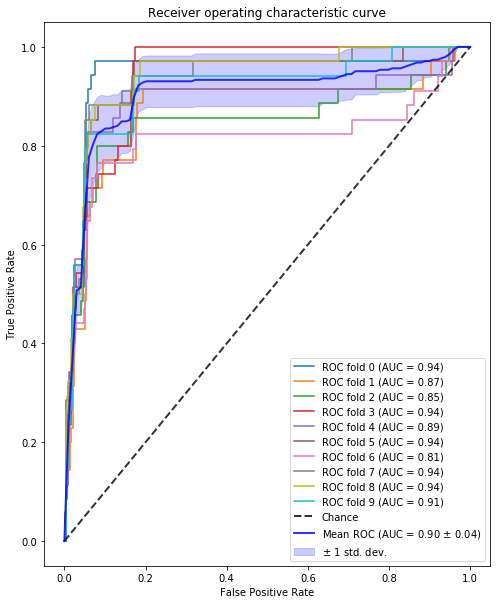

Confusion matrix, without normalization
[[221082  15609]
 [    72    273]]


<Figure size 432x288 with 0 Axes>

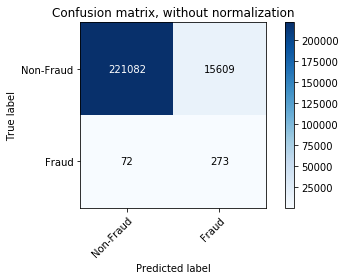

In [18]:
sm = SMOTE(sampling_strategy=0.01, k_neighbors=5)
mean_tpr_sm, std_tpr_sm, mean_auc_sm, std_auc_sm, _, _, cm_sm = roc_analysis(X, y, clf, cv, True, True, True, False, sm)

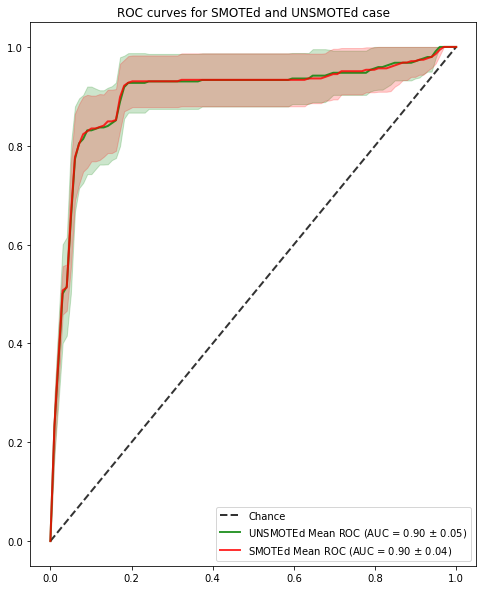

In [19]:
# Combined plot with ROC curves corresponding to the SMOTEd and UNSMOTEd case of the considered classifier
plt.figure(figsize = (8, 10))
plt.title("ROC curves for SMOTEd and UNSMOTEd case")
mean_fpr = np.linspace(0,1,100)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Chance', alpha=.8)

plt.plot(mean_fpr, mean_tpr, color='g',
     label=r'UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), color ='g', alpha=.2)

plt.plot(mean_fpr, mean_tpr_sm, color='r',
     label=r'SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_sm, std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr_sm - std_tpr_sm, 0), np.minimum(mean_tpr_sm + std_tpr_sm, 1), color ='r', alpha=.2)

plt.legend()

26157 2847 6 29
26225 2779 10 25
26197 2807 12 23
26132 2872 6 29
25942 3062 13 22
26019 2985 9 25
25827 3177 9 25
26197 2806 5 29
26186 2817 9 25
25857 3146 15 19


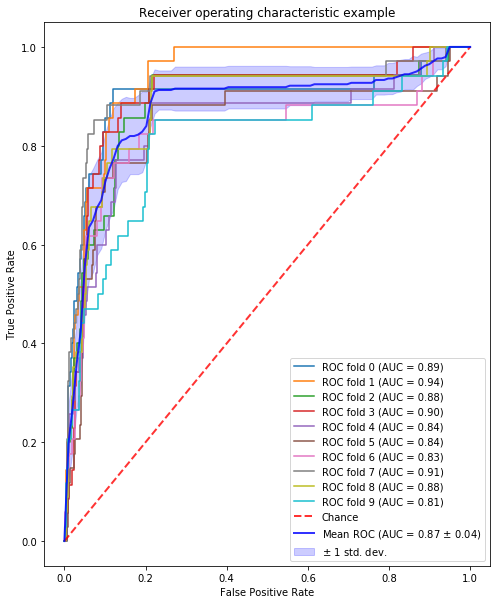

Confusion matrix, without normalization
[[260739  29298]
 [    94    251]]


<Figure size 432x288 with 0 Axes>

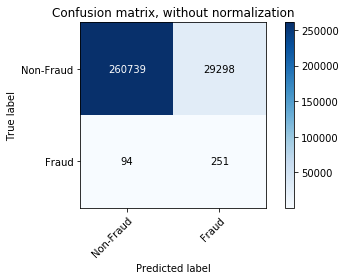

In [8]:
# Modifying class priors for GaussianNB
clf = GaussianNB(priors = [0.99, 0.01])
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

### Logistic Regression

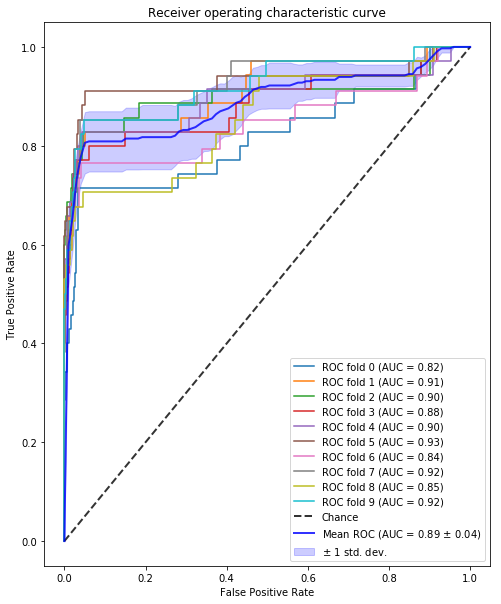

Confusion matrix, without normalization
[[236683      8]
 [   345      0]]


<Figure size 432x288 with 0 Axes>

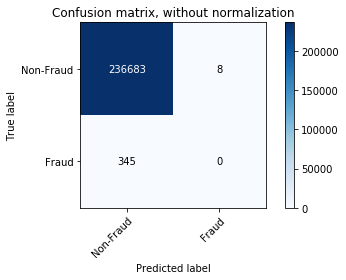

In [20]:
from  sklearn.linear_model import LogisticRegression as LR


clf = LR(C = 1, solver = 'lbfgs', multi_class = 'auto')
mean_tpr, std_tpr, mean_auc, std_auc, _, _, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

In [21]:
# Use cross-validation to determine the best overasmpling ratio
# ratios = np.arange(0.1, 1, 0.1)
ratios = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([5, 10, 100])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, y, clf, cv, 
                                                                                False, False, False, False, sm)
#         print("Oversamping ratio: ", r, ", with mean AUC: ", np.round(m_auc, 5), " +- ", np.round(std_auc, 7),
#               " and mean F1: ", np.round(m_F1, 5), " +- ", np.round(std_F1, 7))
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

Mean AUC:
 [[0.89569646 0.89693574 0.89536033]
 [0.91587981 0.9151252  0.91179272]
 [0.92457601 0.92295815 0.91974875]
 [0.92835413 0.92932349 0.92845769]
 [0.9311196  0.93185977 0.92871403]
 [0.9312605  0.93051099 0.93112469]
 [0.93101944 0.93197861 0.93142518]]
Mean F1:
 [[0.03251293 0.03039128 0.20644598]
 [0.1895148  0.19874504 0.33508873]
 [0.19905779 0.18603152 0.19744442]
 [0.0762102  0.074897   0.07662235]
 [0.01955029 0.0203295  0.0215147 ]
 [0.01590439 0.01624665 0.01697823]
 [0.01514751 0.01528907 0.01596013]]


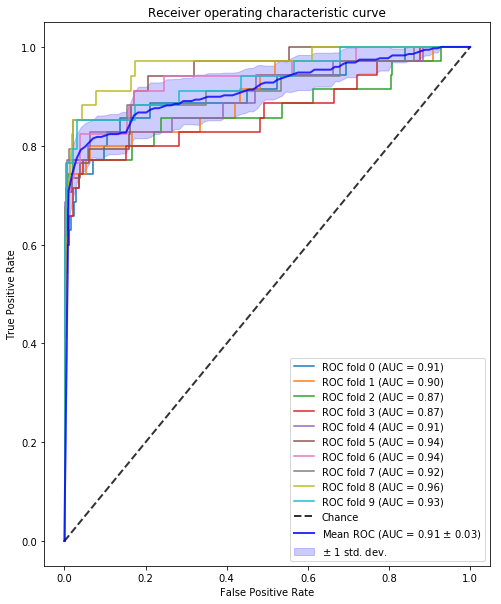

Confusion matrix, without normalization
[[236048    643]
 [   148    197]]


<Figure size 432x288 with 0 Axes>

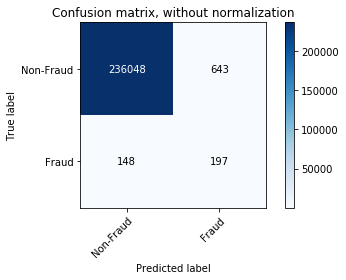

In [23]:
sm = SMOTE(sampling_strategy=0.05, k_neighbors=100)
mean_tpr_sm, std_tpr_sm, mean_auc_sm, std_auc_sm, _, _, cm_sm = roc_analysis(X, y, clf, cv, True, True, True, False, sm)

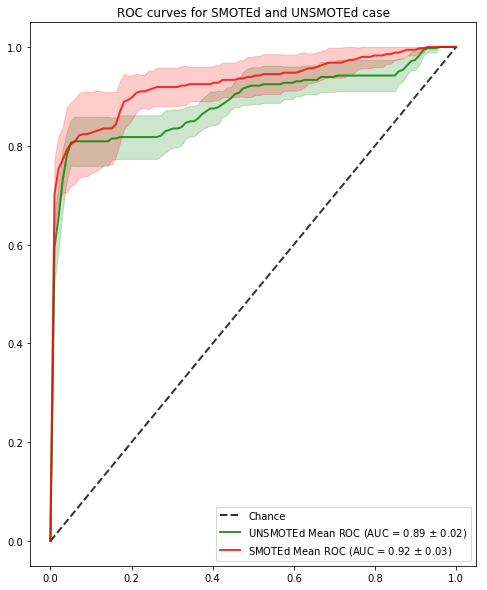

In [31]:
# Combined plot with ROC curves corresponding to the SMOTEd and UNSMOTEd case of the considered classifier
plt.figure(figsize = (8, 10))
plt.title("ROC curves for SMOTEd and UNSMOTEd case")
mean_fpr = np.linspace(0,1,100)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Chance', alpha=.8)

plt.plot(mean_fpr, mean_tpr, color='g',
     label=r'UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), color ='g', alpha=.2)

plt.plot(mean_fpr, mean_tpr_sm, color='r',
     label=r'SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_sm, std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr_sm - std_tpr_sm, 0), np.minimum(mean_tpr_sm + std_tpr_sm, 1), color ='r', alpha=.2)

plt.legend()

### Random Forest

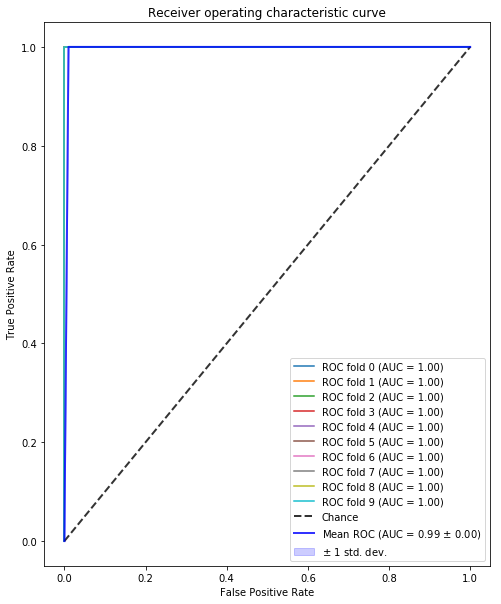

Confusion matrix, without normalization
[[236690      1]
 [     3    342]]


<Figure size 432x288 with 0 Axes>

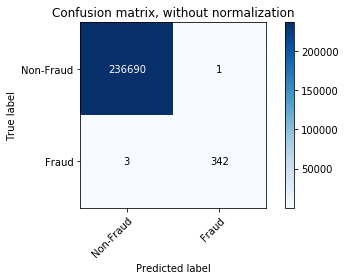

In [46]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
mean_tpr, std_tpr, mean_auc, std_auc, _, _, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

### Linear Discriminant Analysis

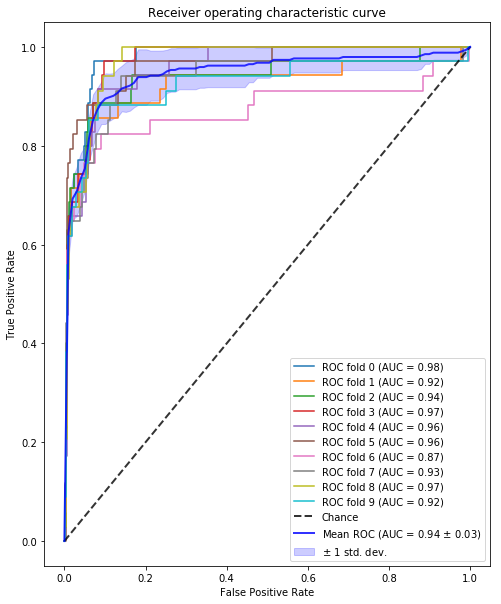

Confusion matrix, without normalization
[[236189    502]
 [   332     13]]


<Figure size 432x288 with 0 Axes>

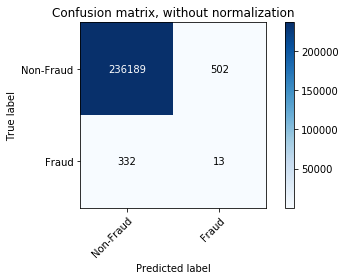

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA(solver='svd')
mean_tpr, std_tpr, mean_auc, std_auc, _, _, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

In [38]:
# Use cross-validation to determine the best overasmpling ratio
# ratios = np.arange(0.1, 1, 0.1)
ratios = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([5, 10, 100])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, y, clf, cv, 
                                                                                False, False, False, False, sm)
#         print("Oversamping ratio: ", r, ", with mean AUC: ", np.round(m_auc, 5), " +- ", np.round(std_auc, 7),
#               " and mean F1: ", np.round(m_F1, 5), " +- ", np.round(std_F1, 7))
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

Mean AUC:
 [[0.9434284  0.94188863 0.93630082]
 [0.94626517 0.94508616 0.94002716]
 [0.94906799 0.94839912 0.94226127]
 [0.95305492 0.95308038 0.94599694]
 [0.95870724 0.95850352 0.95282404]
 [0.96226976 0.96044563 0.95600883]
 [0.96280791 0.96198285 0.95690434]]
Mean F1:
 [[0.12164133 0.1285107  0.17234042]
 [0.1181315  0.11695283 0.07786762]
 [0.067885   0.06889144 0.05240417]
 [0.04358856 0.04352276 0.03833669]
 [0.01984887 0.02067002 0.02047439]
 [0.01593528 0.01639527 0.01684805]
 [0.0155808  0.01563047 0.01605038]]


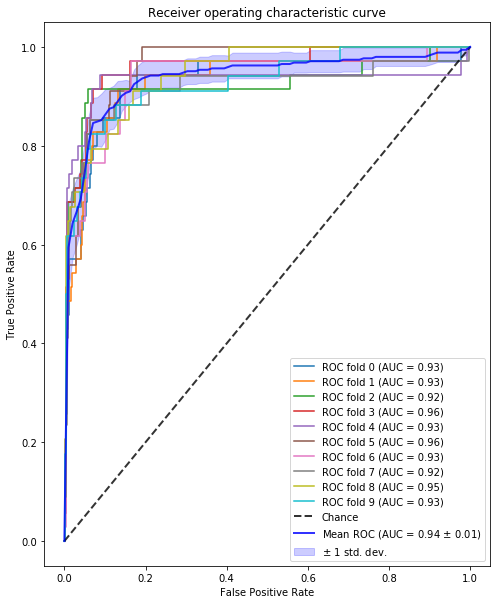

Confusion matrix, without normalization
[[235466   1225]
 [   204    141]]


<Figure size 432x288 with 0 Axes>

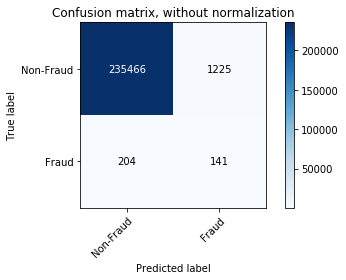

In [42]:
sm = SMOTE(sampling_strategy=0.01, k_neighbors=100)
mean_tpr_sm, std_tpr_sm, mean_auc_sm, std_auc_sm, _, _, cm_sm = roc_analysis(X, y, clf, cv, True, True, True, False, sm)

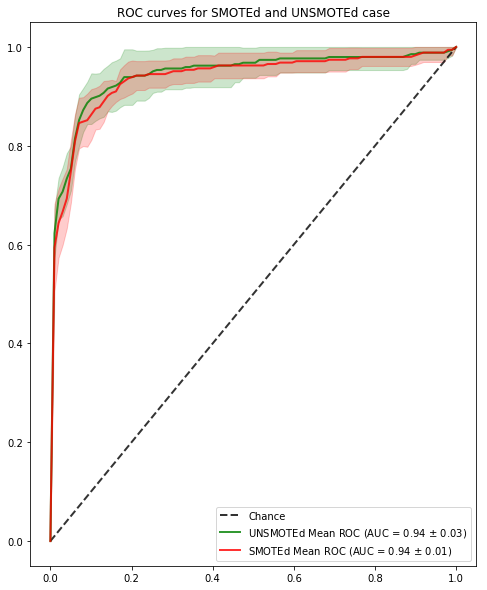

In [43]:
# Combined plot with ROC curves corresponding to the SMOTEd and UNSMOTEd case of the considered classifier
plt.figure(figsize = (8, 10))
plt.title("ROC curves for SMOTEd and UNSMOTEd case")
mean_fpr = np.linspace(0,1,100)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Chance', alpha=.8)

plt.plot(mean_fpr, mean_tpr, color='g',
     label=r'UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), color ='g', alpha=.2)

plt.plot(mean_fpr, mean_tpr_sm, color='r',
     label=r'SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_sm, std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr_sm - std_tpr_sm, 0), np.minimum(mean_tpr_sm + std_tpr_sm, 1), color ='r', alpha=.2)

plt.legend()

### Quadratic Discriminant Analysis

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear

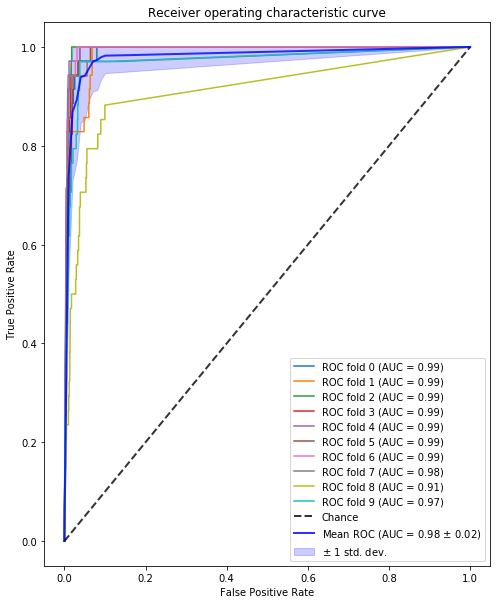

Confusion matrix, without normalization
[[232085   4606]
 [    66    279]]


<Figure size 432x288 with 0 Axes>

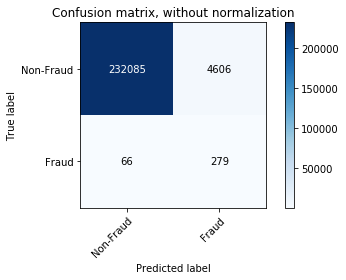

In [44]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()
mean_tpr, std_tpr, mean_auc, std_auc, _, _, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

In [45]:
# Use cross-validation to determine the best overasmpling ratio
# ratios = np.arange(0.1, 1, 0.1)
ratios = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([5, 10, 100])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, y, clf, cv, 
                                                                                False, False, False, False, sm)
#         print("Oversamping ratio: ", r, ", with mean AUC: ", np.round(m_auc, 5), " +- ", np.round(std_auc, 7),
#               " and mean F1: ", np.round(m_F1, 5), " +- ", np.round(std_F1, 7))
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
print("Mean F1:\n", m_F1_cv)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear

Mean AUC:
 [[0.93820103 0.97950053 0.94894865]
 [0.95763312 0.95738747 0.96070588]
 [0.98232389 0.97608587 0.9850161 ]
 [0.92525382 0.94893389 0.97161095]
 [0.96751644 0.87196819 0.97119014]
 [0.96726116 0.92018709 0.97864506]
 [0.95862873 0.95865462 0.93934393]]
Mean F1:
 [[0.12308353 0.14908376 0.17116846]
 [0.14887022 0.14891365 0.16153669]
 [0.1460535  0.13417767 0.15218608]
 [0.12685503 0.13401759 0.15836581]
 [0.12857815 0.14439877 0.16356242]
 [0.13412677 0.17505991 0.14944716]
 [0.14504853 0.18437931 0.13929685]]


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear

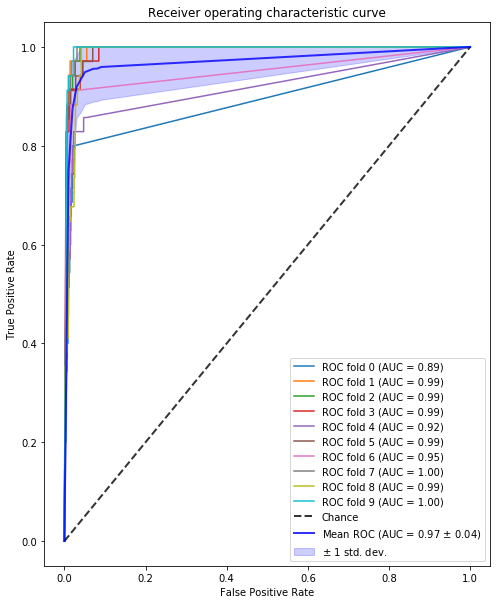

Confusion matrix, without normalization
[[233673   3018]
 [   103    242]]


<Figure size 432x288 with 0 Axes>

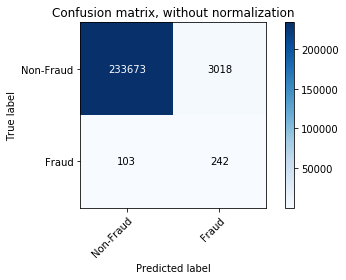

In [49]:
sm = SMOTE(sampling_strategy=0.01, k_neighbors=100)
mean_tpr_sm, std_tpr_sm, mean_auc_sm, std_auc_sm, _, _, cm_sm = roc_analysis(X, y, clf, cv, True, True, True, False, sm)

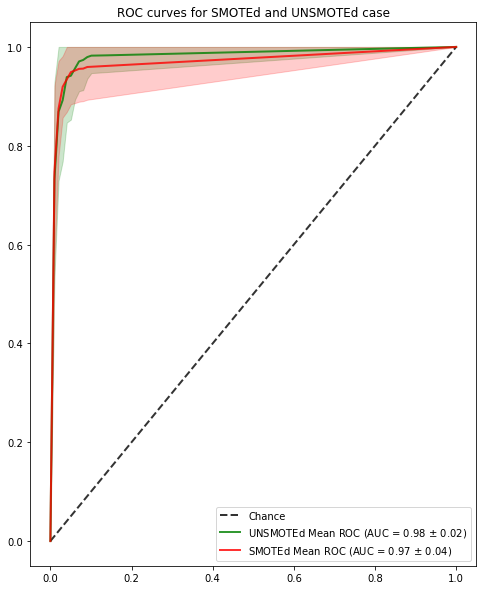

In [50]:
# Combined plot with ROC curves corresponding to the SMOTEd and UNSMOTEd case of the considered classifier
plt.figure(figsize = (8, 10))
plt.title("ROC curves for SMOTEd and UNSMOTEd case")
mean_fpr = np.linspace(0,1,100)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Chance', alpha=.8)

plt.plot(mean_fpr, mean_tpr, color='g',
     label=r'UNSMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), color ='g', alpha=.2)

plt.plot(mean_fpr, mean_tpr_sm, color='r',
     label=r'SMOTEd Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_sm, std_auc_sm),
     lw=2, alpha=.8)
plt.fill_between(mean_fpr, np.maximum(mean_tpr_sm - std_tpr_sm, 0), np.minimum(mean_tpr_sm + std_tpr_sm, 1), color ='r', alpha=.2)

plt.legend()

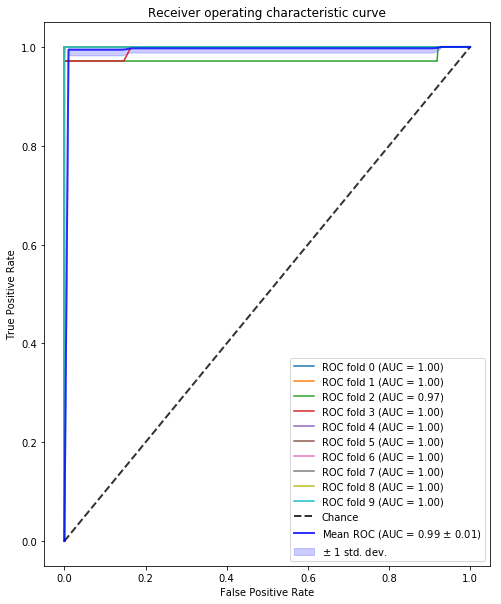

Confusion matrix, without normalization
[[236690      1]
 [     4    341]]


<Figure size 432x288 with 0 Axes>

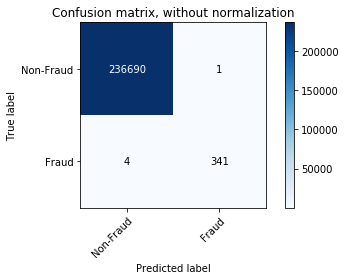

In [51]:
from sklearn.ensemble import AdaBoostClassifier as AdaBoost

clf = AdaBoost(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R')
mean_tpr, std_tpr, mean_auc, std_auc, _, _, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

### Dimensionality Reduction & Scaling

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as StandardScaler
from sklearn.ensemble import VotingClassifier

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

pca = PCA(n_components=0.95, whiten = True)
X_pca = pca.fit_transform(X_scaled)
pca.n_components_

7

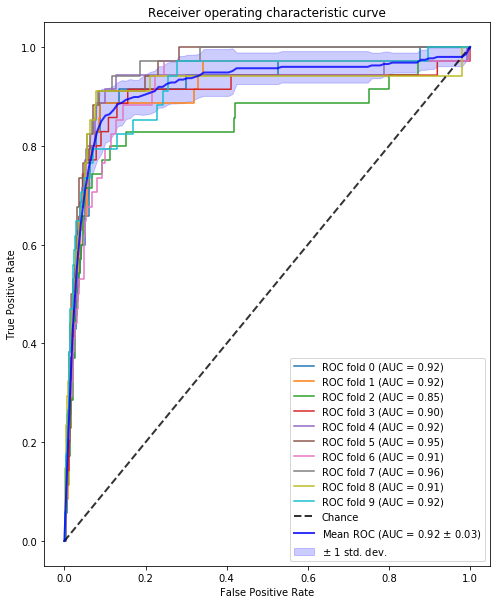

Confusion matrix, without normalization
[[232553   4138]
 [   215    130]]


<Figure size 432x288 with 0 Axes>

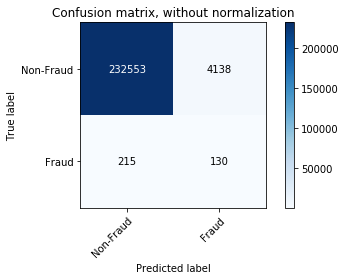

In [63]:
clf = LR(C = 1, solver = 'lbfgs', multi_class = 'auto')
sm = SMOTE(sampling_strategy=0.1, k_neighbors=5)

mean_tpr, std_tpr, mean_auc, std_auc, _, _, cm = roc_analysis(X_pca, y, clf, cv, True, True, True, False, sm)

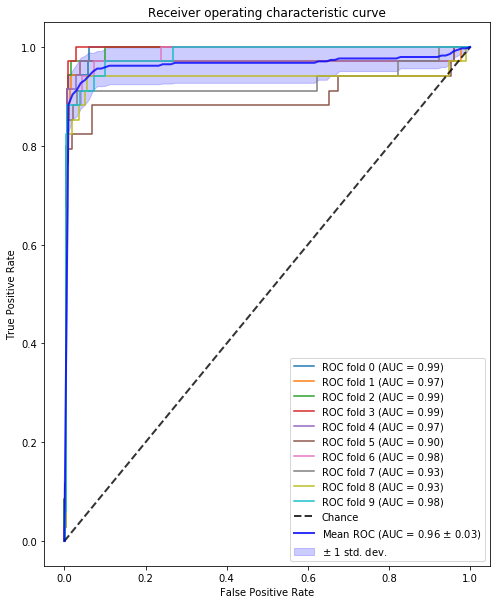

Confusion matrix, without normalization
[[235041   1650]
 [    53    292]]


<Figure size 432x288 with 0 Axes>

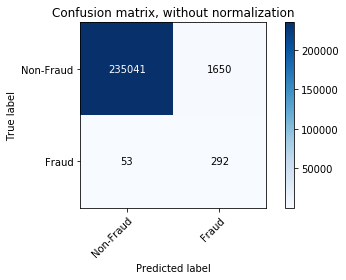

In [69]:
clf = LR(C = 1, solver = 'lbfgs', multi_class = 'auto')
sm = SMOTE(sampling_strategy=0.1, k_neighbors=5)

mean_tpr, std_tpr, mean_auc, std_auc, _, _, cm = roc_analysis(X_scaled, y, clf, cv, True, True, True, False, sm)

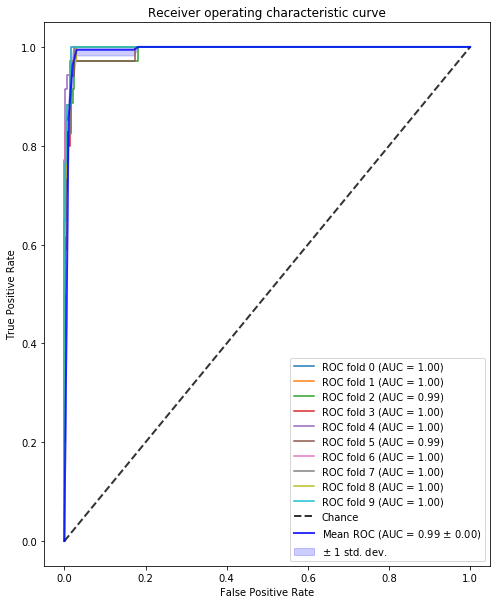

Confusion matrix, without normalization
[[236666     25]
 [   326     19]]


<Figure size 432x288 with 0 Axes>

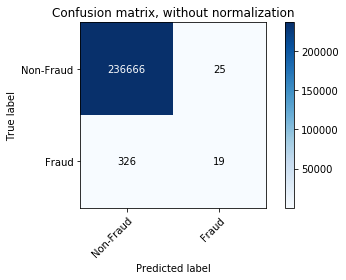

In [74]:
clf1 = LR(C = 1, solver = 'lbfgs', multi_class = 'auto')
clf2 = LDA(solver='svd')
clf3 = QDA()

clf = VotingClassifier(estimators=[('lr', clf1), ('lda', clf2), ('qda', clf3)], voting='soft', n_jobs = -1)
mean_tpr, std_tpr, mean_auc, std_auc, _, _, cm = roc_analysis(X_scaled, y, clf, cv, True, True, True, False)